In [1]:
# Import libraries.
import pandas as pd
import numpy as np
from sqlalchemy import *
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Create connection to sqlite database and read in dataframes. All columns chosen as dataframes are relatively small.
engine = create_engine('sqlite:///data/hopteaming.sqlite')
connection = engine.connect()

nppes = pd.read_sql("SELECT * FROM nppes", con = connection)
hopteaming = pd.read_sql("SELECT * FROM hopteaming", con = connection)

In [3]:
# Create a series to filter datasets by major Nashville hospitals based on name.
only_major_nashville_hospitals = (
    nppes[['npi','organization_name']]\
    .loc[nppes['organization_name']\
         .str.lower()\
         .str.contains('saint thomas|ascension|tristar|vanderbilt',
                       na = False)]\
    .set_index('npi')\
    .squeeze(axis = 1)
)

# Then filter npi dataset by that series.
omnh_npis = (
    nppes['npi']\
    .loc[nppes['npi']\
         .map(only_major_nashville_hospitals)\
         .isin(only_major_nashville_hospitals)]
)

# Then merge in referral dataset in with contact information.
hospital_referrals = (
    hopteaming\
    .loc[hopteaming['to_npi']\
         .isin(omnh_npis)]\
    .merge(nppes,
           left_on = 'from_npi',
           right_on = 'npi',
           how = 'inner')\
    .merge(nppes,
           left_on = 'to_npi',
           right_on = 'npi',
           how = 'inner',
           suffixes = ('_nppes_referral_from', 
                       '_nppes_referral_to'))
)

# Create grouped series by referring npis and transaction count and patient count.
density_transaction_count = (
    hospital_referrals\
    .groupby('from_npi')['transaction_count']\
    .mean()\
    .sort_values(ascending = False)
)

density_patient_count = (
    hospital_referrals\
    .groupby('from_npi')['patient_count']\
    .mean()\
    .sort_values(ascending = False)
)

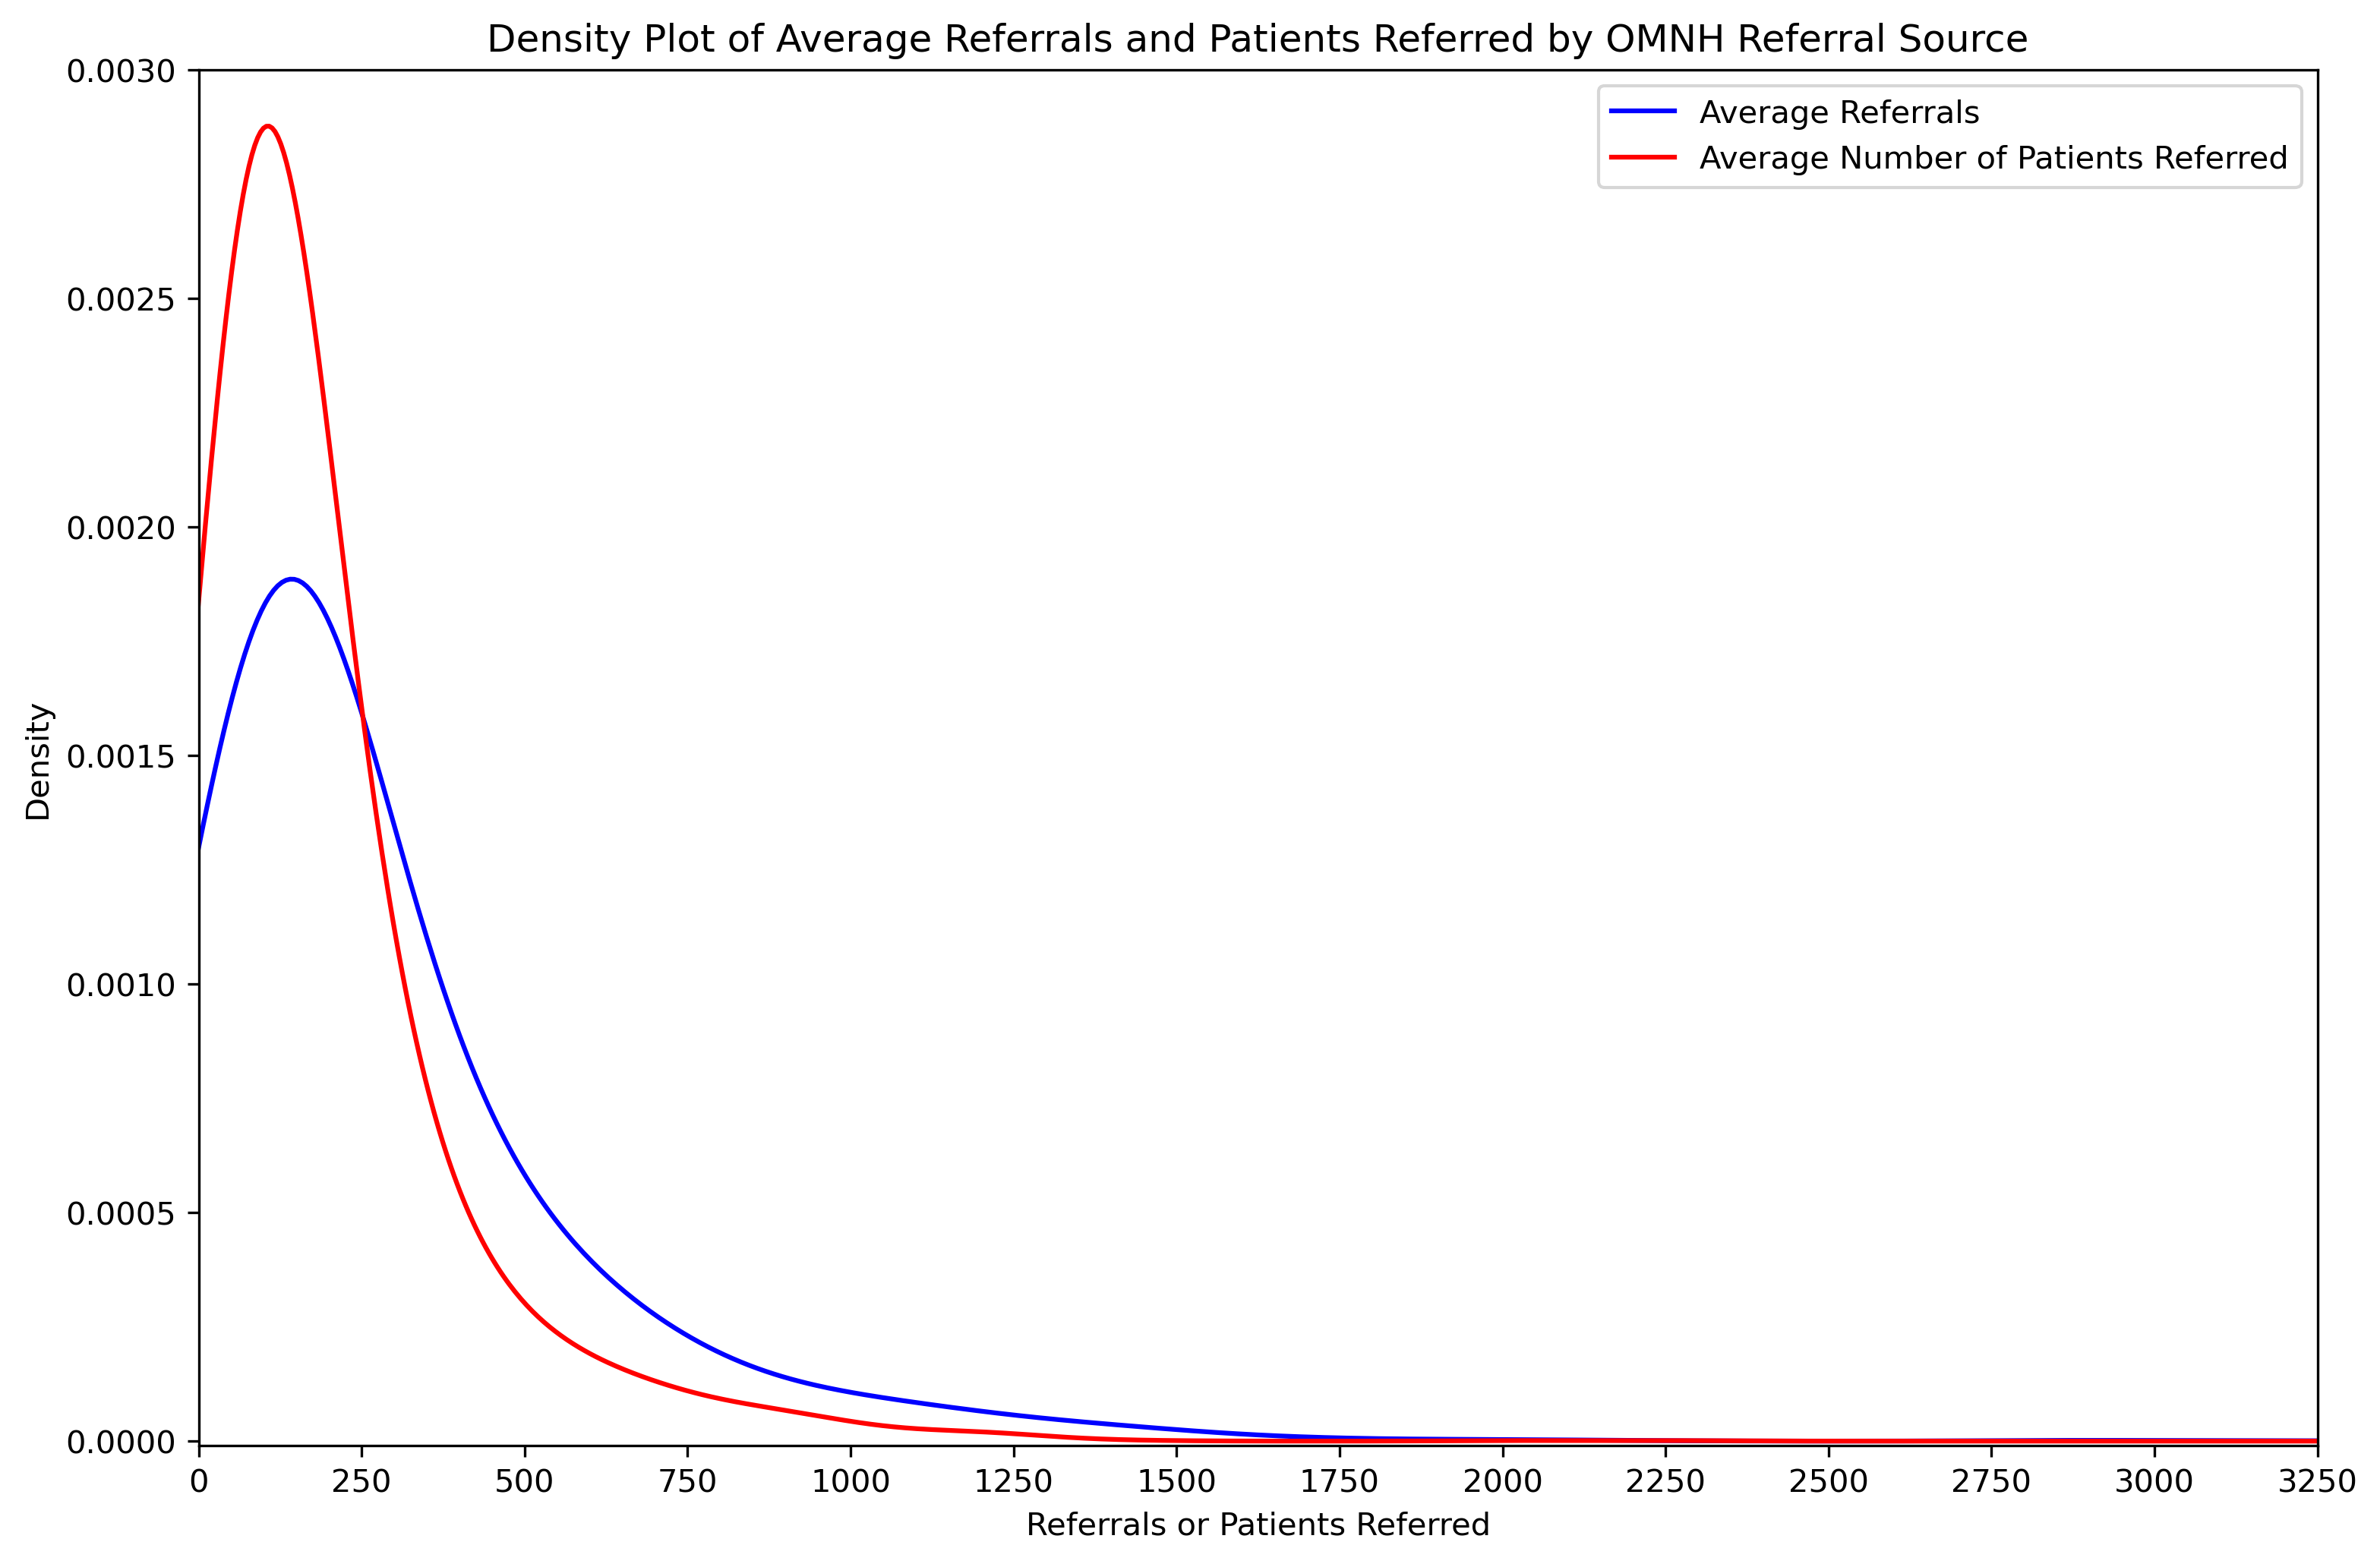

In [4]:
# Plot distributions of patient counts and referral counts.
ymin = -0.00001
ymax = 0.0030
plt.figure(figsize = (12, 8), dpi = 300)
density_transaction_count.plot(kind = 'density', bw_method = 0.5, color = 'b')
density_patient_count.plot(kind = 'density', bw_method = 0.5, color = 'r')
plt.xlim(0, max(density_transaction_count))
plt.xticks(np.arange(0,3500,250))
plt.ylim(bottom = ymin, top = ymax)
plt.xlabel("Referrals or Patients Referred")
plt.title('Density Plot of Average Referrals and Patients Referred by OMNH Referral Source')
plt.legend(labels = ['Average Referrals','Average Number of Patients Referred'])
plt.show();

In [5]:
# Obtain top 20 referral specialties from the patient count and referral count series.
transaction_specialty_count = (
    pd.DataFrame(density_transaction_count[density_transaction_count >= 500].reset_index())\
.merge(hospital_referrals.loc[:, hospital_referrals.columns != 'transaction_count'])\
.rename(columns = {'transaction_count':'average_transaction_count'})\
.value_counts('taxonomy_code_display_name_nppes_referral_from')[:20]\
    .to_frame()\
    .reset_index()\
    .rename(columns = {'taxonomy_code_display_name_nppes_referral_from':'Specialty',
                      0: 'Count'})\
    .sort_values('Count')
)

patient_specialty_count = (
    pd.DataFrame(density_patient_count[density_patient_count >= 500].reset_index())\
.merge(hospital_referrals.loc[:, hospital_referrals.columns != 'patient_count'])\
.rename(columns = {'patient_count':'average_patient_count'})\
.value_counts('taxonomy_code_display_name_nppes_referral_from')[:20]\
    .to_frame()\
    .reset_index()\
    .rename(columns = {'taxonomy_code_display_name_nppes_referral_from':'Specialty',
                      0: 'Count'})\
    .sort_values('Count')
)

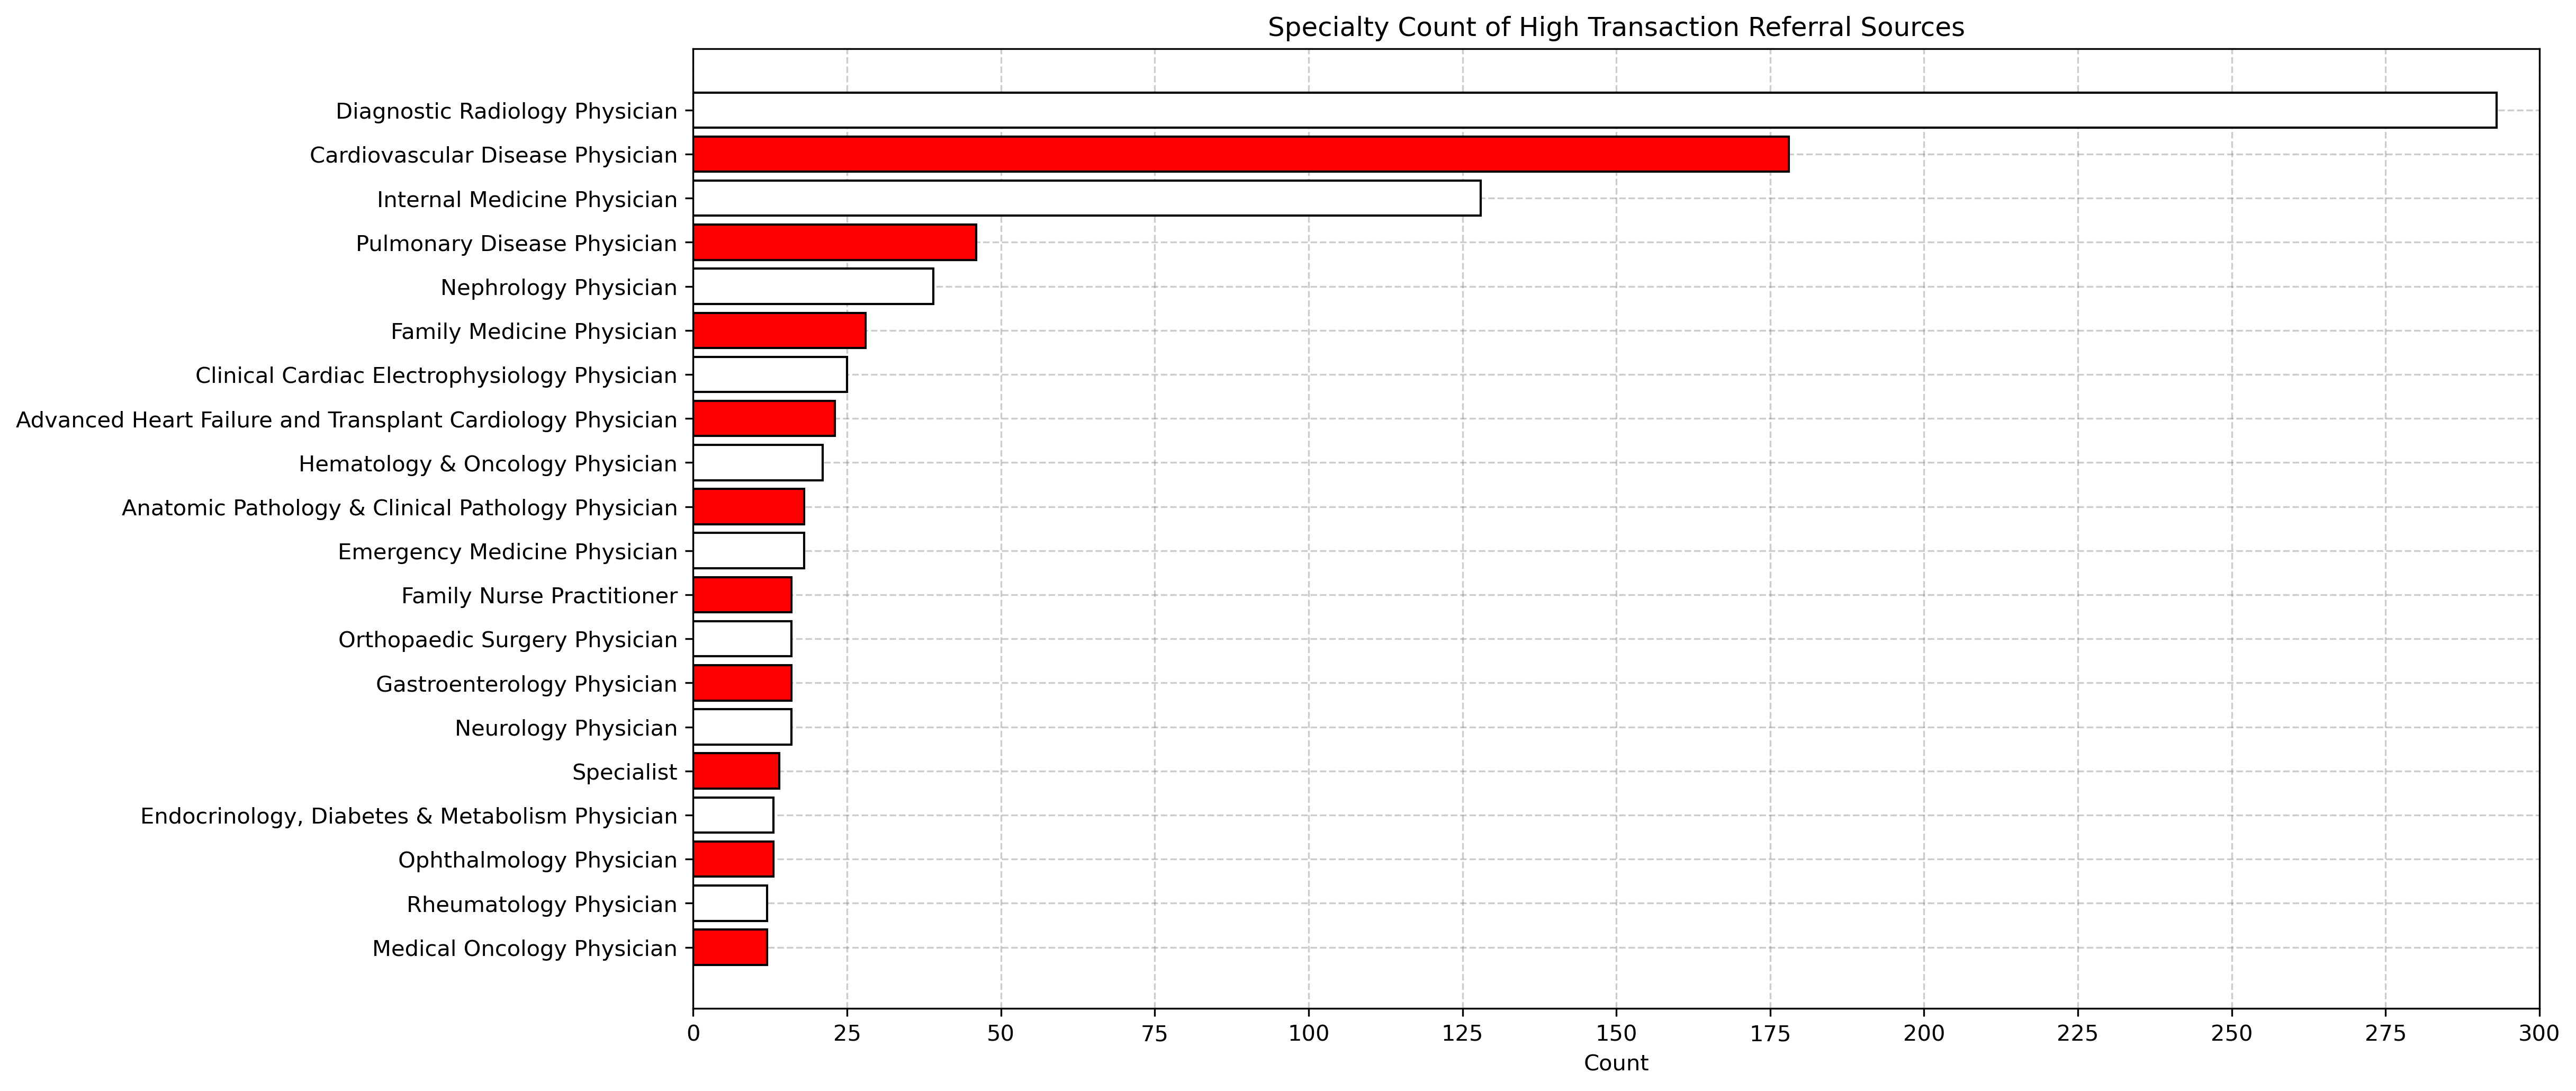

In [6]:
# Then plot counts with barplots.
fig, ax = plt.subplots(figsize = (15, 8), dpi = 300)
ax.barh(y = transaction_specialty_count['Specialty'],
        width = transaction_specialty_count['Count'],
        edgecolor = 'k',
        color = ['red','white'])
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', alpha = 0.4)
plt.xlim(0,300)
plt.xticks(np.arange(0,325,25))
plt.title('Specialty Count of High Transaction Referral Sources')
plt.xlabel('Count')
plt.show();

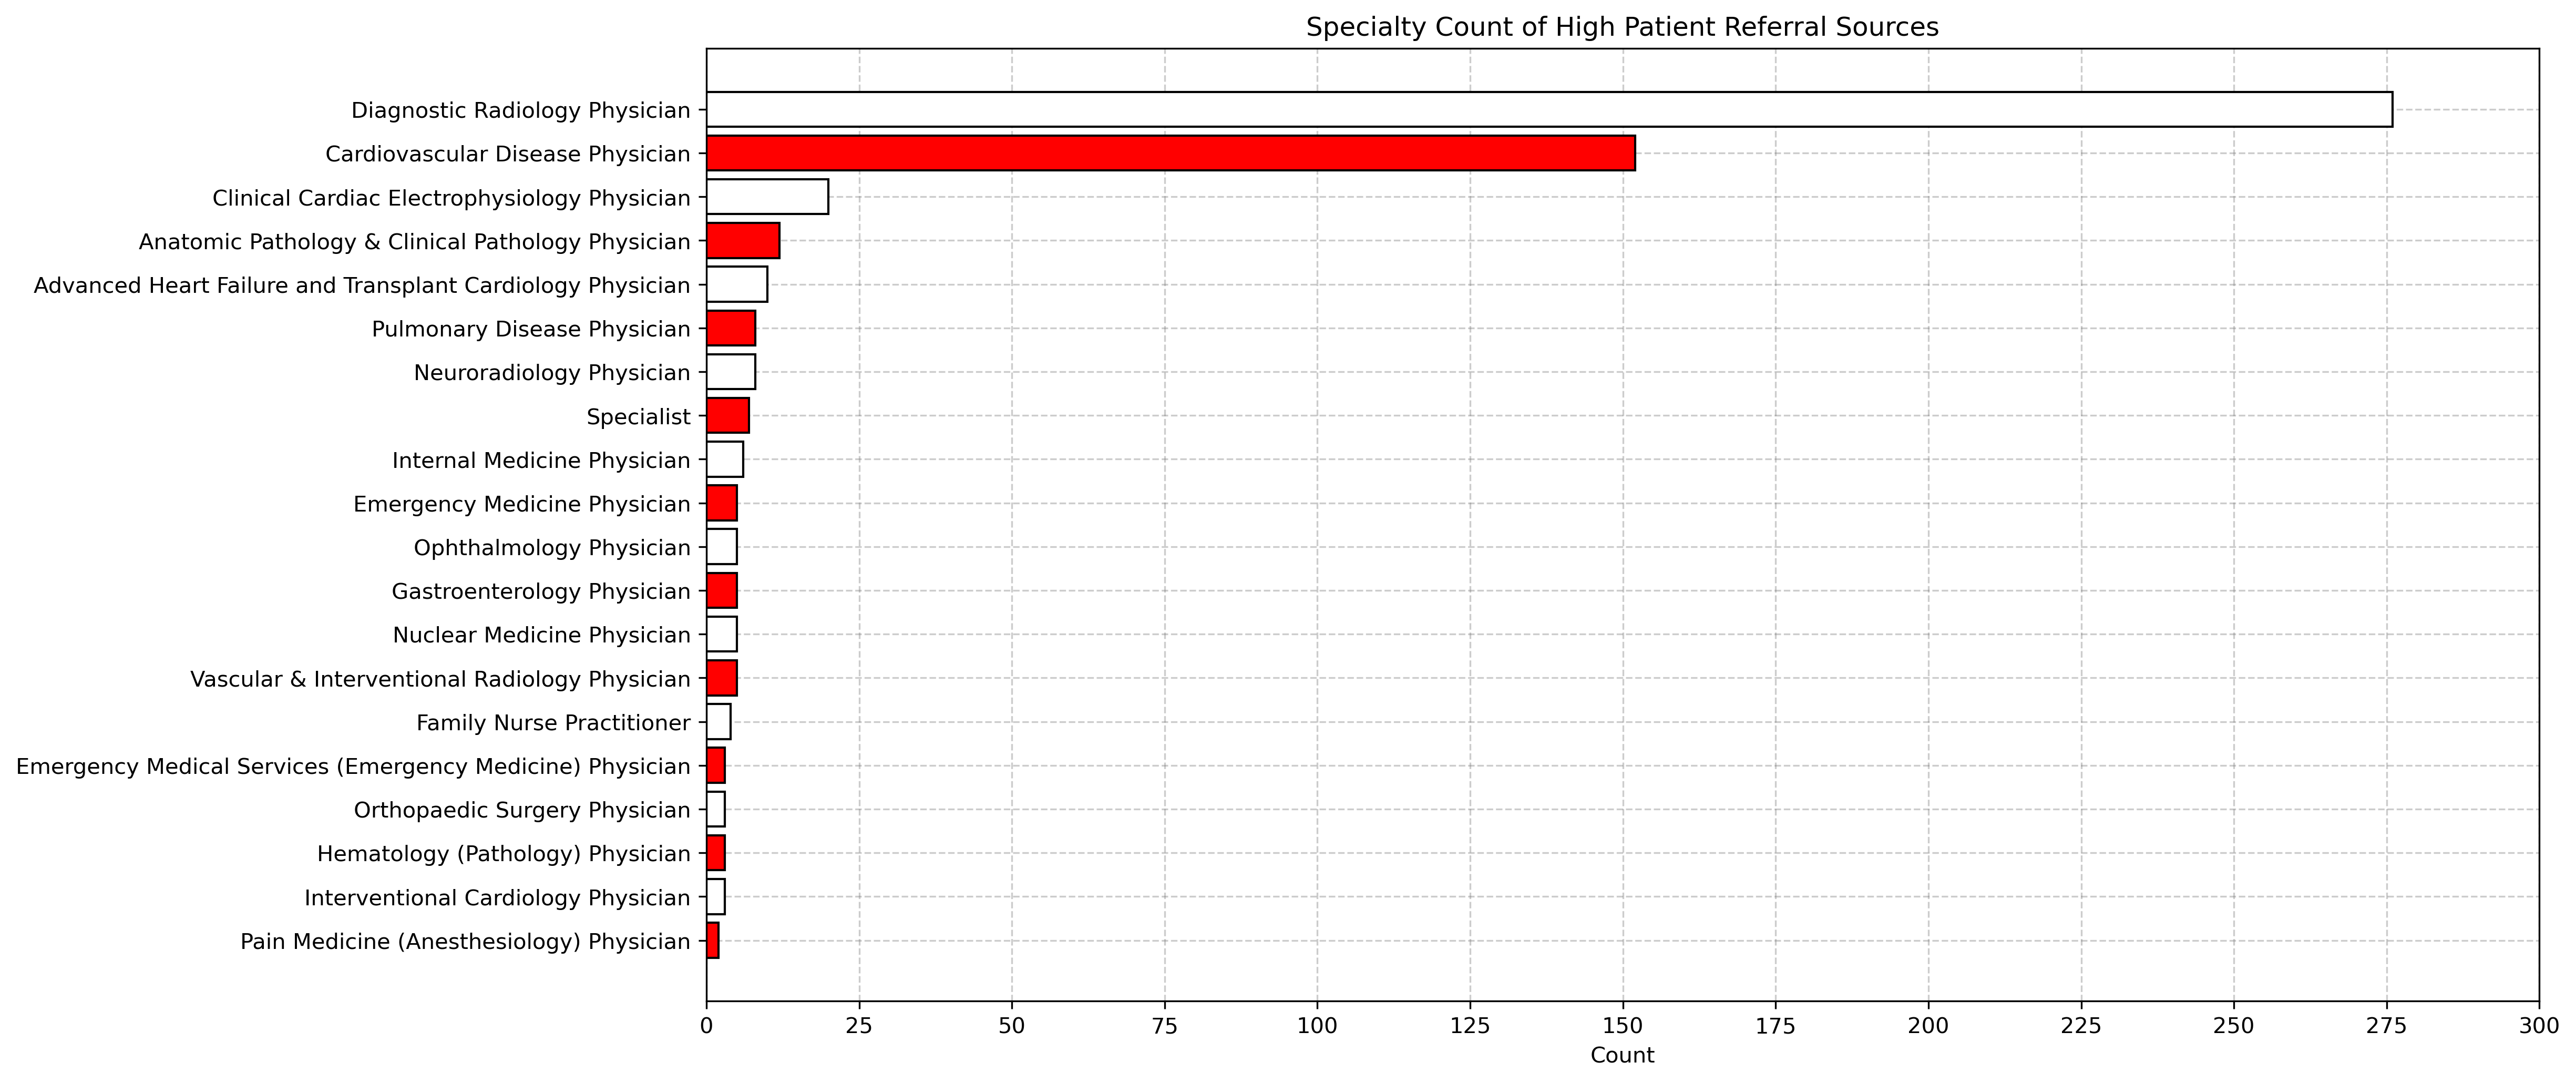

In [7]:
fig, ax = plt.subplots(figsize = (15, 8), dpi = 300)
ax.barh(y = patient_specialty_count['Specialty'],
        width = patient_specialty_count['Count'],
        edgecolor = 'k',
        color = ['red','white'])
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', alpha = 0.4)
plt.xlim(0,300)
plt.xticks(np.arange(0,325,25))
plt.title('Specialty Count of High Patient Referral Sources')
plt.xlabel('Count')
plt.show();

In [8]:
# Create dataframe for log-transformed transaction counts and patient counts.
hexbin_df = (
    density_transaction_count\
    .reset_index()\
    .merge(density_patient_count\
           .reset_index())[['transaction_count','patient_count']]\
    .assign(transaction_count = lambda df: df.apply(lambda x: np.log10(x['transaction_count']), axis = 1),
          patient_count = lambda df: df.apply(lambda x: np.log10(x['patient_count']), axis = 1))
)

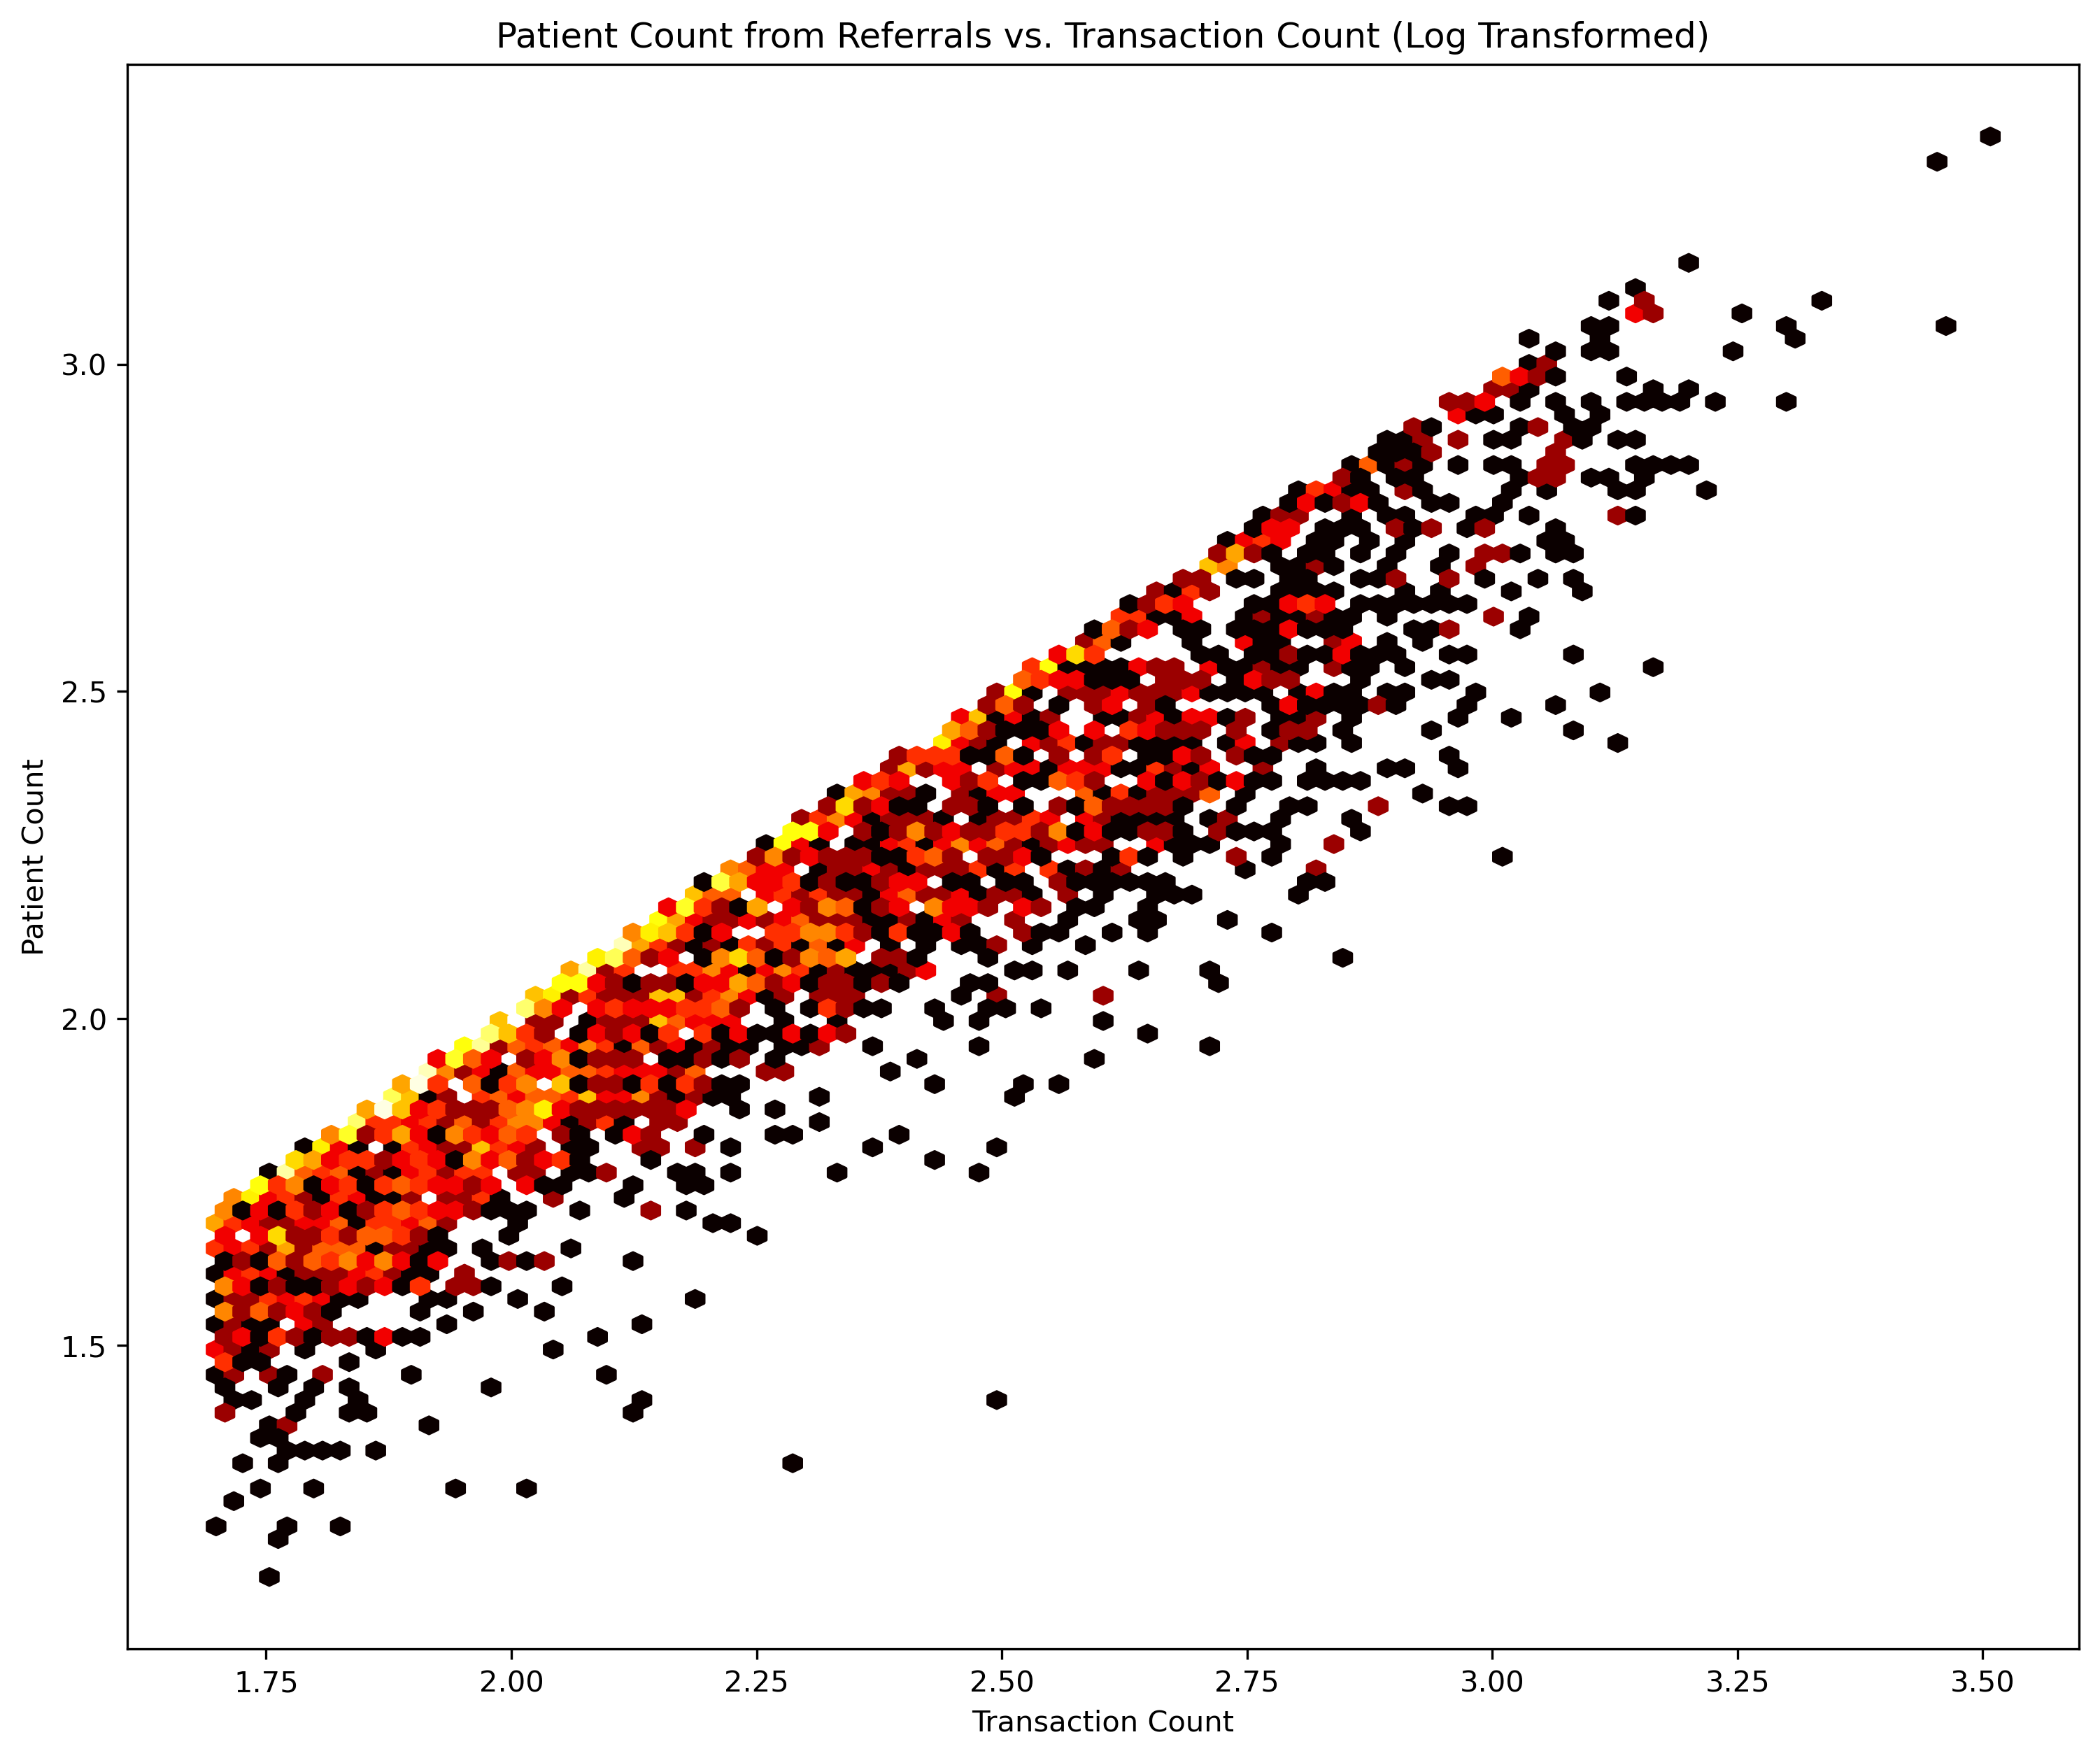

In [9]:
# Plot hexbin graph with transaction counts and patient counts showing almost perfect correlation.
plt.figure(figsize = (12,10), dpi = 300)
plt.hexbin(hexbin_df['transaction_count'],
          hexbin_df['patient_count'],
          cmap = 'hot',
          bins = 'log')
plt.title('Patient Count from Referrals vs. Transaction Count (Log Transformed)')
plt.xlabel('Transaction Count')
plt.ylabel('Patient Count')
plt.show()

In [28]:
# Show number of referrals per zipcode with applicable CBSA name.
hospital_referrals\
.groupby('zipcode_nppes_referral_from')['transaction_count']\
.sum()\
.reset_index()\
.rename(columns = {'zipcode_nppes_referral_from':'Zipcode',
                  'transaction_count': 'Transaction Count'})\
.sort_values('Transaction Count', ascending = False)\
.merge(hospital_referrals[['zipcode_nppes_referral_from', 
                           'cbsa_city_nppes_referral_from']],
      left_on = 'Zipcode',
      right_on = 'zipcode_nppes_referral_from')\
.drop_duplicates()[['Zipcode','Transaction Count','cbsa_city_nppes_referral_from']]\
.rename(columns = {'cbsa_city_nppes_referral_from':'City'})\
.assign(City = lambda df: df['City'].apply(lambda x: x.title()))\
.style.hide(axis = 'index')

Zipcode,Transaction Count,City
37232,591353,Nashville
37205,322721,Nashville
37203,232468,Nashville
37129,160666,Murfreesboro
37072,150035,Goodlettsville
37066,51314,Gallatin
37236,35118,Nashville
37130,30582,Murfreesboro
37087,28426,Lebanon
37075,22246,Hendersonville


In [29]:
hospital_referrals\
.groupby('taxonomy_code_display_name_nppes_referral_from')['transaction_count']\
.sum()\
.reset_index()\
.sort_values('transaction_count', ascending = False)\
.rename(columns = {'taxonomy_code_display_name_nppes_referral_from':'Specialty', 'transaction_count':'Transaction Count'})\
.style.hide(axis = 'index')

Specialty,Transaction Count
Diagnostic Radiology Physician,288640
Internal Medicine Physician,221294
Cardiovascular Disease Physician,204886
Family Medicine Physician,64948
Family Nurse Practitioner,56242
Nephrology Physician,55547
Emergency Medicine Physician,54510
Certified Registered Nurse Anesthetist,47263
Pulmonary Disease Physician,47245
Hematology & Oncology Physician,40511
